In [1]:
from utils import set_root, PhysioLoader

set_root()

/home/guido/miniconda3/envs/physioex/lib/python3.10/site-packages/braindecode/preprocessing/preprocess.py:55: UserWarning: Preprocessing choices with lambda functions cannot be saved.
  warn('Preprocessing choices with lambda functions cannot be saved.')


Current working directory: /home/guido/github/dev/physioex


In [2]:
# importing
import numpy as np
from loguru import logger
import os

import seaborn as sns
from matplotlib import pyplot as plt

sns.set_theme()

from physioex.train.networks import config
from physioex.data import datasets

from tqdm import tqdm
import torch
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

from loguru import logger

from physioex.explain.bands.spectral_gradients import (
    SpectralGradients,
    plot,
    sleep_bands,
)
from captum.attr import IntegratedGradients

logger.remove()

# seed everything with pytorch lightning
from pytorch_lightning import seed_everything
import quantus

seed_everything(42)

Seed set to 42


42

In [3]:
model = "chambon2018"
dataset = {"name": "dreem", "version": "dodh"}
seqlen = 21
loss = "cel"
batch_size = 32

sleep_stages = ["Awake", "N1", "N2", "N3", "REM"]
labels_idx = np.arange(len(sleep_stages)).astype(int)

fold = 6

sleep_bands_names = ["Delta", "Theta", "Alpha", "Sigma", "Beta", "Gamma"]

num_samples = 10

In [4]:
if dataset["version"] is None:
    ckp_path = f"models/cel/{model}/seqlen={seqlen}/{dataset['name']}"
else:
    ckp_path = (
        f"models/cel/{model}/seqlen={seqlen}/{dataset['name']}/{dataset['version']}"
    )

loader = PhysioLoader(
    model_name=model,
    loss_name=loss,
    ckp_path=ckp_path,
    dataset_name=dataset["name"],
    version=dataset["version"],
    use_cache=True,
    sequence_lenght=seqlen,
    batch_size=batch_size,
)

model, train_loader, _, _ = loader.get_fold(fold)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Imposta il modello in modalità di valutazione
model = model.eval().to(device)

sg = SpectralGradients(model)
ig = IntegratedGradients(model)

for inputs, labels in tqdm(train_loader):
    output = model(inputs.to(device)).detach().cpu()
    attr = sg.attribute(inputs.to(device), target=labels.to(device)).detach().cpu()

    ig_attr = ig.attribute(inputs.to(device), target=labels.to(device)).detach().cpu()
    break

attr.shape

  0%|          | 0/583 [00:07<?, ?it/s]


torch.Size([32, 21, 1, 3000, 6])

Target label N3, - Predictions [1.1013808e-03 1.0036989e-03 1.1774823e-01 8.7990773e-01 2.3906783e-04]
Band importance tensor([ 9.0341, -8.5635, -0.9609,  0.3701, -0.3285,  0.2220])


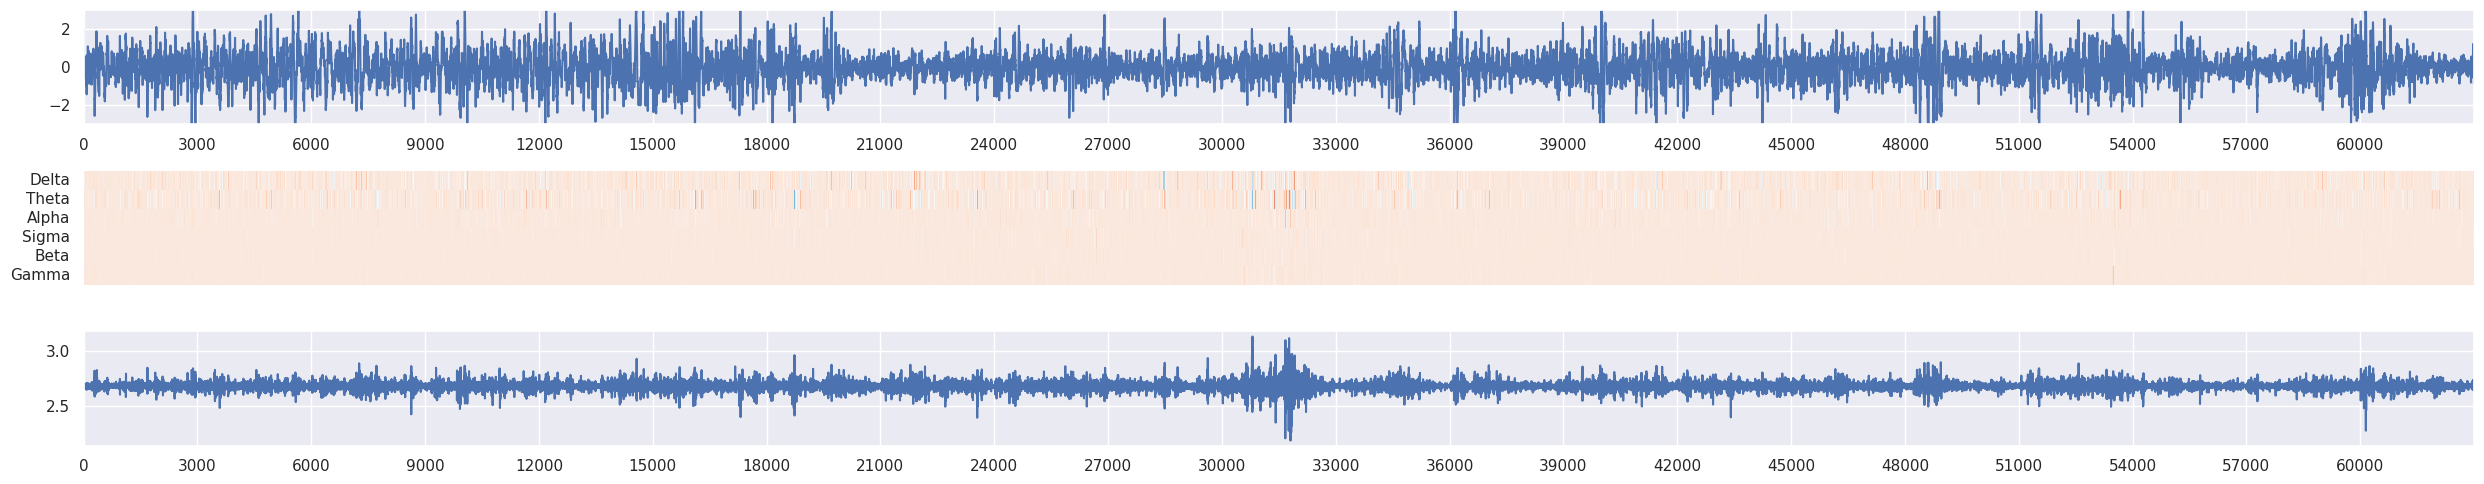

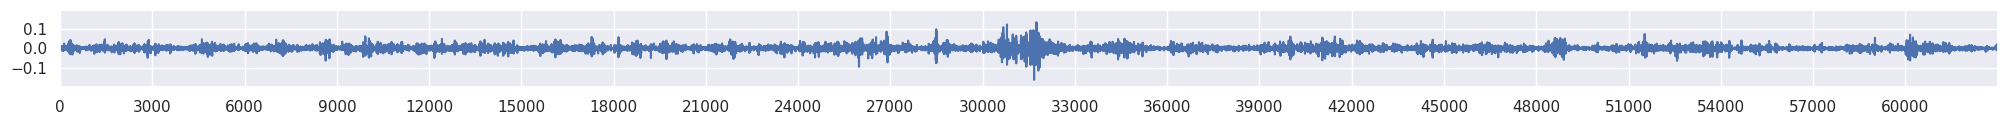

In [5]:
id = 0
S, C, NS, F = attr[id].size()
preds = torch.nn.functional.softmax(output, dim=1).numpy()
print(f"Target label {sleep_stages[labels[id]]}, - Predictions {preds[id]}")

# min max normalization of attr[id]

attr_id = attr[id].reshape(-1)
attr_id = (attr_id - attr_id.min()) / (attr_id.max() - attr_id.min())
attr_id = attr_id.reshape(S, C, NS, F)

# spectral gradients attributions
plot(
    inputs[id].detach().cpu(),
    attr_id,
    labels[id].detach().cpu(),
    band_labels=sleep_bands_names,
)
# print the importance for each band
print(f"Band importance {attr[id].reshape(S*C*NS, F).sum(0)}")
# integrated gradients attributions
plt.figure(figsize=(25, 1))
S, C, NS = inputs[0].size()
ax = sns.lineplot(x=range(S * NS), y=ig_attr[id].reshape(-1).numpy())
ax.set_xticks([])
ax.set_xlim(0, S * NS)
ax.set_ylim(-0.2, 0.2)
ax.set_yticks([-0.1, 0, 0.1])
ax.set_xticks([i * NS for i in range(S)])

In [6]:
def spect_grad_attr(model, inputs, targets, device, filter, **kwargs):
    sg = SpectralGradients(model)
    inputs = torch.tensor(inputs).reshape(-1, S, C, NS)
    targets = torch.tensor(targets)
    attr = sg.attribute(inputs.to(device), target=targets.to(device)).detach().cpu()
    attr = attr[..., filter].reshape(inputs.size(0), 1, -1)
    return attr.numpy()


def int_grads_attr(model, inputs, targets, device, **kwargs):
    ig = IntegratedGradients(model)
    inputs = torch.tensor(inputs)  # .reshape(-1, S, C, NS)
    targets = torch.tensor(targets)
    attr = ig.attribute(inputs.to(device), target=targets.to(device)).detach().cpu()
    attr = attr  # .reshape(inputs.size(0), -1)
    return attr.numpy()

In [7]:
metric = quantus.Infidelity()

sm = []
for f in range(F):
    spect_metr = metric(
        model,
        inputs.reshape(inputs.size(0), 1, -1).numpy(),
        labels.numpy(),
        device=device,
        explain_func=spect_grad_attr,
        explain_func_kwargs={"filter": f},
    )
    sm.append(spect_metr)


print(f"Spectral gradients metric {spect_metr}")

RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [1, 63000]

In [ ]:
ig_metr = metric(
    model,
    inputs.reshape(inputs.size(0), -1).numpy(),
    labels.numpy(),
    device=device,
    explain_func=spect_grad_attr,
)
print(f"Integrated gradients metric {ig_metr}")

{'spectral_gradients': {'complexity': 10.389941664946507,
  'model-parameter-randomisation': 0.5385515350709649},
 'integrated_gradients': {'complexity': 10.156753097326945,
  'model-parameter-randomisation': 0.6887324610791367}}